idea: can we use something like a siamese net to tell the difference between the pre and post images?

#### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.vision import learner
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
image_crops_dir_post = data_dir / "classification_crops_post"
image_crops_dir_pre = data_dir / "classification_crops_pre"
models_path = data_dir / "models"

#### Sanity check after running `process_data_classification.py`
- basic idea of the script is to use the polygons from the 'post' image to also crop the 'pre' image...

In [3]:
image_crops_dir_post.ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/classification_crops_post/400a3600-9543-47e5-a993-dc8e8d632c8d.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops_post/c5628941-0317-460a-b2ae-ea78d34bd042.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops_post/ad029848-f650-4f03-adf0-da0c4d43d02f.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops_post/046695ca-5f20-480c-bcfa-b03a5e64ce73.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops_post/d1ab21b3-3a4d-44a2-979b-0a44edd264ac.png')]

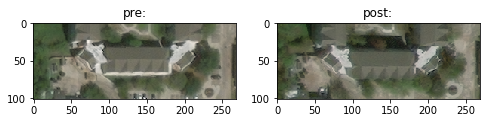

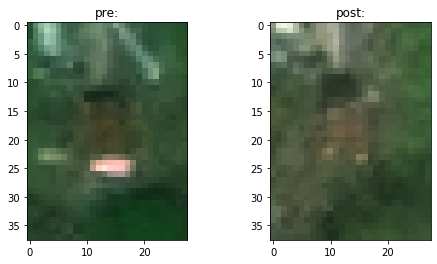

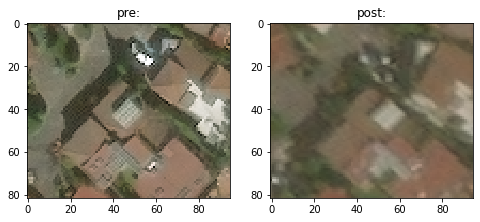

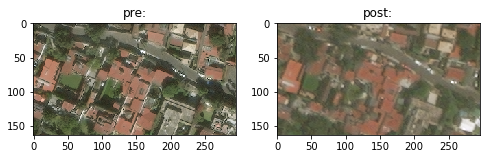

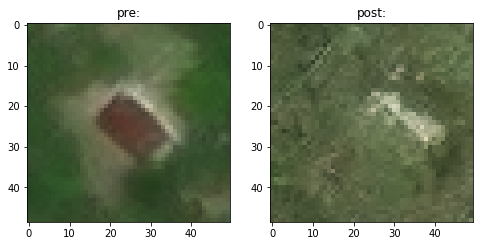

In [4]:
def plot_pre_post(image_fname, add_title=True):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    axs = ax.ravel()
    pre_img = np.array(PIL.Image.open(image_crops_dir_pre/image_fname))
    post_img = np.array(PIL.Image.open(image_crops_dir_post/image_fname))
    axs[0].imshow(pre_img)
    axs[1].imshow(post_img)
    if add_title:
        axs[0].set_title(f'pre:')
        axs[1].set_title(f'post:')
_=[plot_pre_post(x.name) for x in image_crops_dir_post.ls()[:5]]

In [5]:
def get_train_valid_ids(classification_labels_df, img_id_col, valid_pct=0.1, random_seed=42):
    np.random.seed(random_seed)
    unique_img_ids = classification_labels_df[img_id_col].unique()
    np.random.shuffle(unique_img_ids)
    train_img_ids = unique_img_ids[:int(len(unique_img_ids) * (1- valid_pct))]
    valid_img_ids = unique_img_ids[int(len(unique_img_ids) * (1- valid_pct)):]
    
    train_ids = classification_labels_df[classification_labels_df[img_id_col].isin(train_img_ids)].crop_filename.values
    valid_ids = classification_labels_df[classification_labels_df[img_id_col].isin(valid_img_ids)].crop_filename.values
    
    return train_ids, valid_ids

def is_valid_func(img_fname, valid_ids):
    id = Path(img_fname).name
    return id in valid_ids


In [6]:
train_pre_post = pd.read_csv(data_dir/"train_pre_post.csv")
train_pre_post['crop_filename']= train_pre_post.uuid.apply(lambda x: f"{x}.png")
train_pre_post.head()

,uuid,img_id_pre,img_id_post,label,crop_filename
0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8.png
1,437988fc-fb7e-4b0e-8ccf-403015a737b3,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,437988fc-fb7e-4b0e-8ccf-403015a737b3.png
2,63d78637-7c40-40c7-a1b3-55152a64415a,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,63d78637-7c40-40c7-a1b3-55152a64415a.png
3,31ccdff0-b7f7-4884-8e55-d35e4d2c1770,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,31ccdff0-b7f7-4884-8e55-d35e4d2c1770.png
4,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b.png


In [7]:

train_ids, valid_ids = get_train_valid_ids(train_pre_post, "img_id_pre")
valid_func = partial(is_valid_func,valid_ids=valid_ids)

In [8]:
mean, std = torch.tensor(imagenet_stats)
mean.shape, std.shape, mean, std

(torch.Size([3]),
 torch.Size([3]),
 tensor([0.4850, 0.4560, 0.4060]),
 tensor([0.2290, 0.2240, 0.2250]))

In [9]:
def _resolve_tfms(tfms:TfmList):
    "Resolve every tfm in `tfms`."
    for f in listify(tfms): f.resolve()
        
# class ImageTuple(Image):
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj= (img1,img2)
#         print(img1.data.max(), img2.data.max())
        #normalisation
        self.data = [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
#         self.data = [img1.data, img2.data]
    def apply_tfms(self, tfms, **kwargs):
        # using the do_resolve in this way here is important to make sure the same transform is applied to both images
        self.img1 = self.img1.apply_tfms(tfms, do_resolve=True, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, do_resolve=False, **kwargs)
        self.data = [self.img1.data,self.img2.data]
        return self

    
    def to_one(self): 
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])
    
class ImageTupleList(ImageList):
    _label_cls=CategoryList
    
    def __init__(self, items, path_pre=None, **kwargs):
        super().__init__(items, **kwargs)
        self.path_pre = path_pre
        self.copy_new.append('path_pre')
        
    def get(self, i):
        img1 = super().get(i)

        img2_filename = Path(self.path_pre)/Path(self.items[i]).name
        return ImageTuple(img1, open_image(img2_filename))
    
    def reconstruct(self, t:Tensor): 
#         return ImageTuple(Image(t[0]*std[...,None,None] +mean[...,None,None]),
#             Image(t[1]*std[...,None,None] +mean[...,None,None]))
        return ImageTuple(Image(t[0]),Image(t[1]))
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        
    @classmethod
    def from_df(cls, df, path_pre, path_post, **kwargs):
        res = super().from_df(df, path=path_post, path_pre=path_pre, **kwargs)
#         res.path = path_post
        return res


In [10]:

size=128
bs=16
partial_data_frac=0.2
src = (ImageTupleList
       .from_df(train_pre_post, path_post=image_crops_dir_post, path_pre=image_crops_dir_pre, cols=['crop_filename'])
       .use_partial_data(partial_data_frac)
       .split_by_valid_func(valid_func)
       .label_from_df(cols='label'))
data = (src
        .transform(get_transforms(
            do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75
        ), size=size, tfm_y=False)
        .databunch(bs=bs))

# data = (src.transform((None,None), size=size, tfm_y=False).databunch(bs=bs))


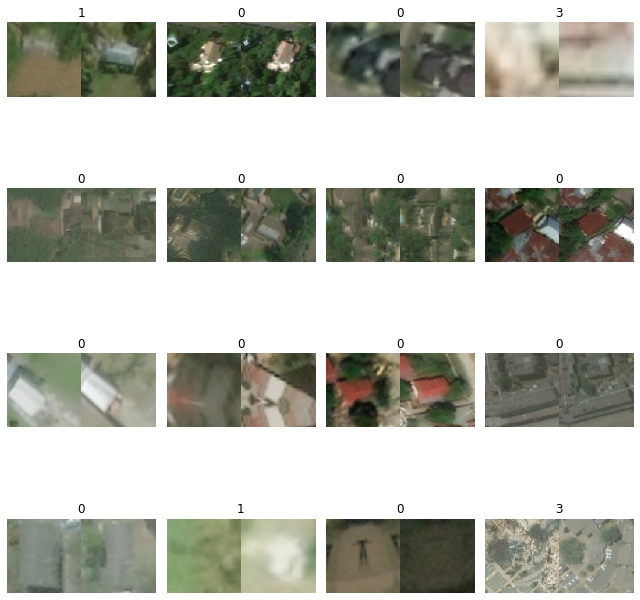

In [11]:
data.show_batch()

In [12]:
class SiameseNet(nn.Module):
    def __init__(self, architecture=models.resnet34, 
                 lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False, n_classes=4):
        super(SiameseNet, self).__init__()
        self.architecture= architecture
        self.emb_sz = emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.architecture, pretrained=True, 
            cut=learner.cnn_config(self.architecture)['cut'])
        self.head = learner.create_head(num_features_model(self.body) , self.emb_sz, 
                                        self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)
        print(self.cnn, 'self.cnn')
        self.output = nn.Linear(num_features_model(self.cnn), n_classes)

                                  
    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        dist = torch.abs(output1-output2)
    
        
        return self.output(dist)

    def get_embedding(self, x):
        return self.cnn(x)

In [13]:
def to_onehot(indices, num_classes):
    """Convert a tensor of indices of any shape `(N, ...)` to a
    tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
    input's device`.
    """
    onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                         device=indices.device)
    return onehot.scatter_(1, indices.unsqueeze(1), 1)
def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))#

In [ ]:
# class ContrastiveLoss(nn.Module):
#     """Takes embeddings of two samples and a target label 
#     """
#     def __init__(self, margin=5.):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin
#     def forward(self, ops, target, size_average=True):
#         op1, op2 = ops[0], ops[1]
#         dist = F.pairwise_distance(op1, op2)
#         pdist = dist*target
#         ndist = dist*(1-target)
#         loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
#         return loss.mean() if size_average else losses.sum()

In [25]:

model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
siamese_learner = Learner(data, model, loss_func=F.cross_entropy, model_dir=models_path, metrics=[accuracy])

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

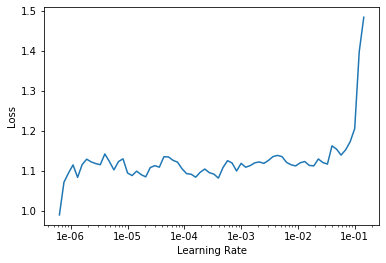

In [21]:
# siamese_learner.lr_find()
siamese_learner.recorder.plot()

In [26]:
siamese_learner.fit_one_cycle(3, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.009450,0.972619,0.717378,09:09
1,1.002114,0.955373,0.727134,01:19
2,0.995127,0.951491,0.727134,01:19


In [30]:
siamese_learner.metrics = [accuracy, f1]
siamese_learner.fit_one_cycle(3, max_lr=0.5e-5)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.974867,0.941336,0.731707,0.641354,01:20
1,0.992073,0.935125,0.732012,0.645127,01:20
2,0.929478,0.936602,0.735671,0.648150,01:21


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f3d7fb2f0>
Traceback (most recent call last):
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f3d7fb2f0>
Traceback (most recent call last):
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
Exception ignored in: <function _Mul

Traceback (most recent call last):
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f3d7fb2f0>
Traceback (most recent call last):
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _

  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    w.join()
AssertionError: can only join a child process
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f3d7fb2f0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f3d7fb2f0>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call last):
AssertionError: can only join a child process
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py",

    self._shutdown_workers()
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0f3d7fb2f0>
Traceback (most recent call last):
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/wwymak/anaconda3/envs/fastai-solaris/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pi

In [31]:
siamese_learner.save('11Dec_siamese_learner_resnet34')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


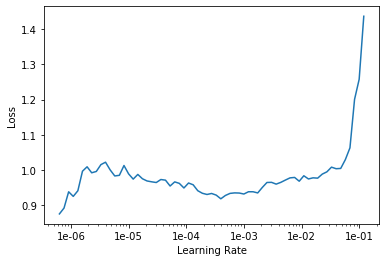

In [33]:
siamese_learner.unfreeze()
siamese_learner.lr_find()
siamese_learner.recorder.plot()

In [34]:
siamese_learner.fit_one_cycle(3, max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.953699,0.925682,0.731098,0.643219,01:20
1,0.980167,0.940176,0.737500,0.648294,01:17
2,0.937311,0.926597,0.737500,0.643312,01:18


In [35]:
siamese_learner.fit_one_cycle(10, max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.918020,0.941607,0.739024,0.644174,01:18
1,0.907574,0.940895,0.738110,0.656159,01:19
2,0.905069,0.934875,0.731402,0.646081,01:19
3,0.950926,0.936586,0.736890,0.650597,01:19
4,0.934492,0.935681,0.742073,0.657730,01:19
5,0.887742,0.927096,0.739634,0.651800,01:19
6,0.916704,0.934123,0.738110,0.653385,01:20
7,0.876035,0.930665,0.739024,0.650947,01:23
8,0.985338,0.922221,0.742988,0.655715,01:23
9,0.918536,0.937706,0.740854,0.649737,01:23


In [36]:
siamese_learner.save('11Dec_siamese_learner_resnet34')

In [46]:
def euclidean_dist( x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    
    return torch.pow(x - y, 2).sum(2)

In [16]:
#change to adding the 2 vectors?
class SiameseNet(nn.Module):
    def __init__(self, architecture=models.resnet34, 
                 lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False, n_classes=4):
        super(SiameseNet, self).__init__()
        self.architecture= architecture
        self.emb_sz = emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.architecture, pretrained=True, 
            cut=learner.cnn_config(self.architecture)['cut'])
        self.head = learner.create_head(num_features_model(self.body) , self.emb_sz, 
                                        self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)

        self.output = nn.Linear(num_features_model(self.cnn), n_classes)

                            
    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        
        dist = output1 + output2
#         print('dist', dist.shape)
        
        return self.output(dist)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


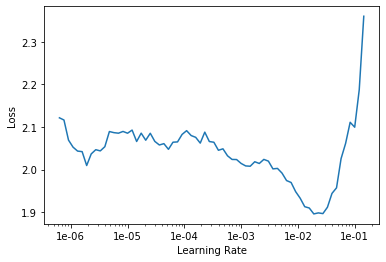

In [50]:
del siamese_learner
gc.collect()

model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
siamese_learner = Learner(data, model, loss_func=F.cross_entropy, model_dir=models_path, metrics=[accuracy, f1])
siamese_learner.to_fp16()
siamese_learner.lr_find()
siamese_learner.recorder.plot()


In [ ]:
siamese_learner.fit_one_cycle(6, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.099664,0.871041,0.734451,0.552799,01:38
1,0.763494,0.682408,0.772256,0.675375,01:39
2,0.646612,0.614621,0.791768,0.719480,01:41
3,0.569751,0.584849,0.781098,0.728795,01:40
4,0.542800,0.600740,0.774085,0.725268,01:40


In [22]:
# focal loss works well before, can we get it to work here?
class CombinedLoss(nn.Module):
    
    def __init__(self, gamma=2., alpha=0.25):
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=self.gamma, alpha=self.alpha)
#         bce_dice = BCEDiceLoss()
#         lovaz_loss = LovaszLossBinary()
#         dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = focal_loss(logit, target) #+ 0.2 * dice_loss(logit, y)
        return total_loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


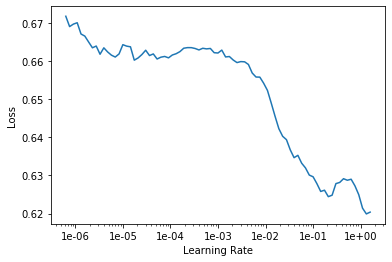

In [19]:
del siamese_learner
gc.collect()

model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
siamese_learner = Learner(data, model, loss_func=F.cross_entropy, model_dir=models_path, metrics=[accuracy, f1])
siamese_learner.to_fp16()
siamese_learner.loss_func =CombinedLoss();
siamese_learner.lr_find()
siamese_learner.recorder.plot()

In [20]:
siamese_learner.fit_one_cycle(6, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.526422,0.504563,0.743902,0.720985,10:01
1,0.518791,0.504028,0.750305,0.747037,01:41
2,0.533160,0.504257,0.748780,0.743584,01:41
3,0.527157,0.509399,0.731402,0.716010,01:41
4,0.529646,0.506711,0.740244,0.731138,01:41
5,0.516656,0.504484,0.742683,0.734453,01:40


In [22]:
del siamese_learner
gc.collect()

model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
siamese_learner = Learner(data, model, loss_func=F.cross_entropy, model_dir=models_path, metrics=[accuracy, f1])
siamese_learner.to_fp16()
siamese_learner.loss_func =CombinedLoss(alpha=0.75);
siamese_learner.fit_one_cycle(6, max_lr=1e-4);

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.229690,0.225696,0.646037,0.589769,01:44
1,0.217575,0.209632,0.742683,0.731193,01:43
2,0.221138,0.209799,0.741159,0.733229,01:39
3,0.219594,0.228221,0.636890,0.562968,01:40
4,0.216814,0.214382,0.713415,0.678565,01:45
5,0.219524,0.215602,0.704268,0.662740,01:44


In [23]:
del siamese_learner
gc.collect()

model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
siamese_learner = Learner(data, model, loss_func=F.cross_entropy, model_dir=models_path, metrics=[accuracy, f1])
siamese_learner.to_fp16()
siamese_learner.loss_func =CombinedLoss(alpha=0.5);
siamese_learner.fit_one_cycle(6, max_lr=1e-4);

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.379607,0.370167,0.674695,0.593612,01:41
1,0.370472,0.349822,0.763719,0.741847,01:40
2,0.369932,0.355353,0.745122,0.739249,01:41
3,0.369821,0.362076,0.715549,0.683955,01:41
4,0.365830,0.355809,0.748780,0.745040,01:41
5,0.370165,0.356363,0.744512,0.734170,01:42


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


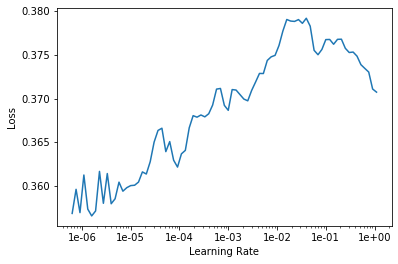

In [24]:
siamese_learner.lr_find()
siamese_learner.recorder.plot();

In [25]:
siamese_learner.fit_one_cycle(6, max_lr=1e-6);

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.367693,0.356592,0.747256,0.743910,01:44
1,0.361542,0.355953,0.747866,0.744814,01:44
2,0.369130,0.357411,0.740244,0.727210,01:44
3,0.371129,0.356914,0.741768,0.730216,01:40
4,0.365742,0.356880,0.740244,0.727662,01:40
5,0.367548,0.355670,0.747256,0.741096,01:39


In [26]:
siamese_learner.save('11Dec_siamese_learner_resnet34')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


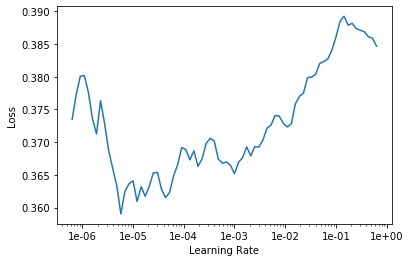

In [27]:
siamese_learner.unfreeze()
siamese_learner.lr_find()
siamese_learner.recorder.plot();

In [28]:
siamese_learner.fit_one_cycle(6, max_lr=1e-6);

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.364298,0.355952,0.748171,0.744251,01:42
1,0.366471,0.356802,0.744817,0.739467,01:43
2,0.371930,0.355835,0.745427,0.737922,01:40
3,0.372386,0.356131,0.743902,0.735795,01:41
4,0.369236,0.356223,0.744512,0.736635,01:42
5,0.371145,0.355804,0.748476,0.746402,01:41


In [29]:
siamese_learner.save('11Dec_siamese_learner_resnet34')

In [30]:
siamese_learner.fit_one_cycle(6, max_lr=1e-7);

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.370352,0.356260,0.745122,0.736928,01:41
1,0.367721,0.355854,0.747866,0.742440,01:42
2,0.363637,0.355746,0.749085,0.746719,01:42
3,0.361658,0.355357,0.747866,0.742278,01:44
4,0.366369,0.356046,0.746646,0.741094,01:44
5,0.370948,0.356128,0.747256,0.742148,01:43


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


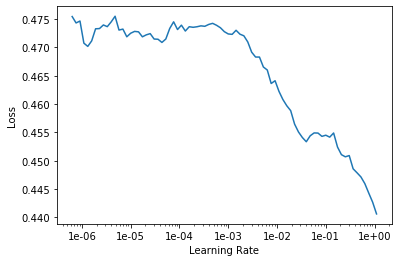

In [31]:
del siamese_learner
gc.collect()

model = SiameseNet(architecture=models.resnet50).cuda()
apply_init(model.head, nn.init.kaiming_normal_)
siamese_learner = Learner(data, model, model_dir=models_path, metrics=[accuracy, f1])
siamese_learner.to_fp16()
siamese_learner.loss_func =CombinedLoss(alpha=0.5);
siamese_learner.lr_find()
siamese_learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.361756,0.354918,0.753659,0.753659,02:26
1,0.364074,0.354918,0.753659,0.753659,02:27
2,0.361834,0.354918,0.753659,0.753659,02:27


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


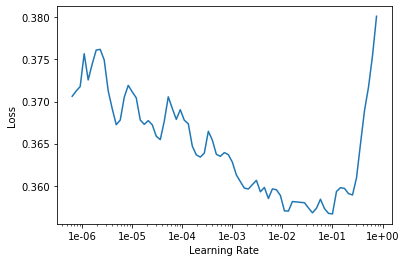

In [32]:
siamese_learner.fit_one_cycle(3, max_lr=1e-3);
siamese_learner.lr_find();
siamese_learner.recorder.plot();

In [33]:
siamese_learner.save('11Dec_siamese_learner_resnet50')

resume investigation after 1 day(and tbh the previous result is a bit weird-- why is the loss/metrics all the same for 3 epochs

In [14]:
model = SiameseNet(architecture=models.resnet50).cuda()
apply_init(model.head, nn.init.kaiming_normal_)
siamese_learner = Learner(data, model, model_dir=models_path, metrics=[accuracy, f1])
siamese_learner.to_fp16()
siamese_learner.loss_func =CombinedLoss(alpha=0.5)
siamese_learner.load('11Dec_siamese_learner_resnet50');

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

NameError: name 'CombinedLoss' is not defined

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


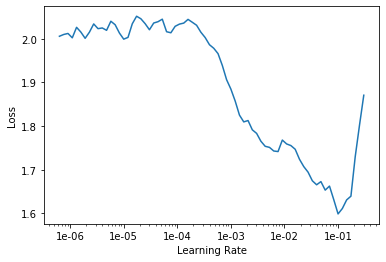

In [15]:
siamese_learner.lr_find();
siamese_learner.recorder.plot();

In [16]:
siamese_learner.fit_one_cycle(3, max_lr=1e-3);

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.913261,1.971223,0.556098,0.289598,06:49
1,0.818891,0.941061,0.747561,0.615295,02:25
2,0.845516,0.963134,0.755183,0.491028,02:24


In [17]:
siamese_learner.fit_one_cycle(3, max_lr=1e-5);

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.821226,0.924908,0.754573,0.532322,02:25
1,0.804267,0.955061,0.754268,0.490362,02:24
2,0.803991,0.962303,0.754268,0.467907,02:26


In [30]:
class SiameseNet(nn.Module):
    def __init__(self, architecture=models.resnet34, 
                 lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False, n_classes=4):
        super(SiameseNet, self).__init__()
        self.architecture= architecture
        self.emb_sz = emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.architecture, pretrained=True, 
            cut=learner.cnn_config(self.architecture)['cut'])
        self.head = learner.create_head(num_features_model(self.body) , self.emb_sz, 
                                        self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)

        self.output = nn.Linear(num_features_model(self.cnn), n_classes)

                            
    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        
        dist = torch.abs(output1 - output2)
#         print('dist', dist.shape)
        
        return self.output(dist)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


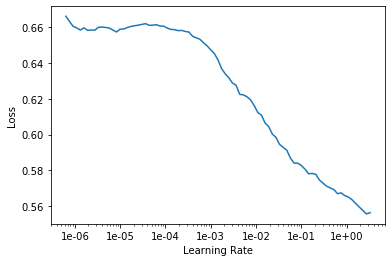

In [33]:
# del siamese_learner
#del model
gc.collect()
model = SiameseNet(architecture=models.resnet18).cuda()
apply_init(model.head, nn.init.kaiming_normal_)
siamese_learner = Learner(data, model, model_dir=models_path, metrics=[accuracy, f1])
siamese_learner.to_fp16()
siamese_learner.loss_func =CombinedLoss();
siamese_learner.lr_find()
siamese_learner.recorder.plot()

In [34]:
siamese_learner.fit_one_cycle(3, max_lr=1e-3);

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.499952,0.505877,0.753659,0.753659,01:06
1,0.496038,0.509679,0.753659,0.751689,01:05
2,0.510497,0.508957,0.753659,0.752321,01:04


In [35]:
siamese_learner.loss_func =CombinedLoss(alpha=0.5);
siamese_learner.fit_one_cycle(6, max_lr=1e-3);

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.359857,0.359844,0.753659,0.752282,01:06
1,0.359754,0.360118,0.753659,0.752665,01:05
2,0.362704,0.359432,0.753659,0.752705,01:06
3,0.356271,0.360473,0.753659,0.752685,01:06
4,0.356421,0.358546,0.753659,0.753275,01:07
5,0.355590,0.358538,0.753659,0.753059,01:05


In [37]:
siamese_learner.save('11Dec_siamese_learner_resnet18')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


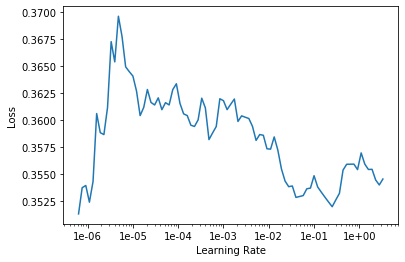

In [36]:
siamese_learner.lr_find()
siamese_learner.recorder.plot();

In [38]:
siamese_learner.fit_one_cycle(6, max_lr=1e-6);

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.357363,0.359141,0.753659,0.753265,01:08
1,0.350864,0.358181,0.753659,0.753442,01:08
2,0.360040,0.358299,0.753659,0.753275,01:07
3,0.353200,0.358248,0.753659,0.753236,01:05
4,0.354737,0.358292,0.753659,0.753275,01:07
5,0.363671,0.358224,0.753659,0.753265,01:07


In [39]:
siamese_learner.save('11Dec_siamese_learner_resnet18')